### Model Training Using Transfer Learning (MobileNetV2)

This notebook focuses on training a traffic sign recognition model using
transfer learning with MobileNetV2.  
A pretrained model is used as a feature extractor to significantly improve
classification accuracy and training efficiency compared to a basic CNN.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model


d:\WorkSpace\Python Works\TSR_CNN_Project\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### Dataset Paths

This section defines paths for the training and testing datasets.
The same directory structure is reused to maintain consistency
across all notebooks in the project.


In [3]:
DATA_DIR = "../data"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")


### Image Configuration

MobileNetV2 performs better with higher-resolution images.
Images are resized and normalized before being fed into the model.


In [4]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 32


### Data Preprocessing and Augmentation

This step prepares image data generators for training and testing.
Data augmentation is applied only to training data to improve generalization.


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 4438 images belonging to 85 classes.
Found 1288 images belonging to 85 classes.


### Load Pretrained MobileNetV2

This section loads the MobileNetV2 model pretrained on ImageNet.
The top classification layers are excluded, and pretrained layers
are frozen to preserve learned visual features.


In [7]:
base_model = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Custom Classification Head

This section adds custom fully connected layers on top of the pretrained
base model to adapt it for traffic sign classification.


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,432,917 (9.28 MB)

 Trainable params: 174,933 (683.33 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Model Training

This step trains the transfer learning model on the traffic sign dataset.
Since pretrained features are used, fewer epochs are required
to achieve good performance.


In [11]:
EPOCHS = 15

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data
)


Epoch 1/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.3107 - loss: 2.9122 - val_accuracy: 0.5000 - val_loss: 1.9787
Epoch 2/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 0.5052 - loss: 1.8591 - val_accuracy: 0.5683 - val_loss: 1.5829
Epoch 3/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 32s 230ms/step - accuracy: 0.5735 - loss: 1.5159 - val_accuracy: 0.5963 - val_loss: 1.4067
Epoch 4/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 219ms/step - accuracy: 0.6140 - loss: 1.3140 - val_accuracy: 0.6320 - val_loss: 1.2875
Epoch 5/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - accuracy: 0.6494 - loss: 1.1624 - val_accuracy: 0.6444 - val_loss: 1.2285
Epoch 6/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - accuracy: 0.6769 - loss: 1.0612 - val_accuracy: 0.6623 - val_loss: 1.1698
Epoch 7/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 30s 218ms/step - accuracy: 0.6886 - loss: 1.0015 - val_accuracy: 0.6661 - val_loss: 1.1458
Epoch 8/15
139/139 ━━━━━━━━━━━━━━━━━━━━ 31s 220ms/step - accuracy: 0.7062 - loss: 0

### Training Performance Visualization

This section plots training and validation accuracy and loss.
These plots help assess convergence and detect overfitting.



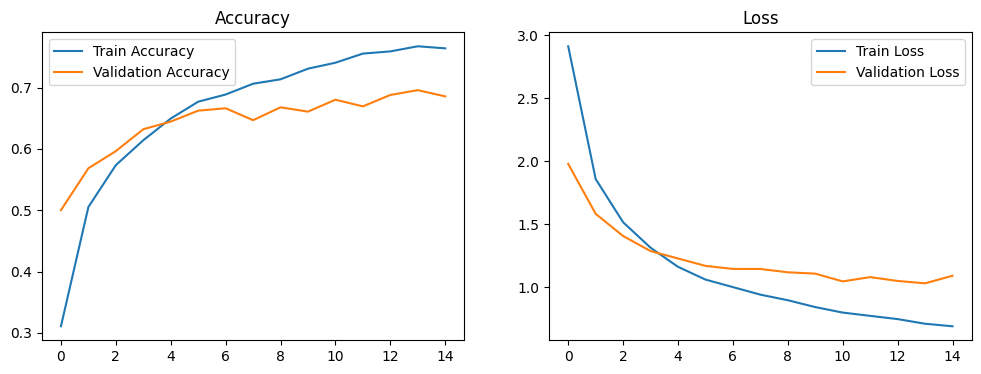

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()


### Save Trained Model

This section saves the trained MobileNetV2-based model.
The saved model will be used for evaluation and real-time webcam detection.


In [13]:
os.makedirs("../models", exist_ok=True)
model.save("../models/traffic_sign_mobilenet.keras")

print("MobileNetV2 model saved successfully")


MobileNetV2 model saved successfully
